In [1]:
#import paskages
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from keras.layers import *
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# pip install opencv-python

In [3]:
# pip install seaborn

In [4]:
# Set directories
train_dir = 'data/Alzheimer_s Dataset/train'
test_dir = 'data/Alzheimer_s Dataset/test'

In [5]:
# # Get class names
# class_names = os.listdir(train_dir)
# Get class names and filter out .DS_Store
class_names = [name for name in os.listdir(train_dir) if name != '.DS_Store']
print(class_names)


['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


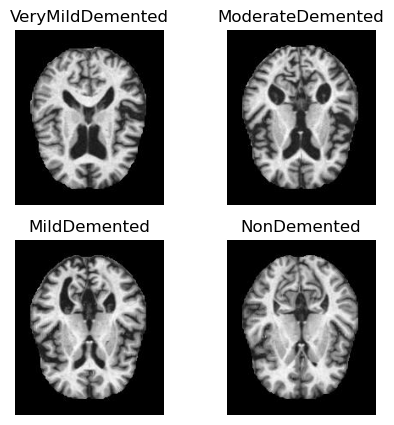

In [6]:
# Print sample images from each class
plt.figure(figsize=(5, 5))
for i, class_name in enumerate(class_names):
    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_dir, class_name)))
    img_path = os.path.join(train_dir, class_name, img_name)
    
    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [7]:
# Function to preprocess images
def preprocess_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [8]:
# Load image paths and labels
X = []
y = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        X.append(os.path.join(class_dir, img_name))
        y.append(class_name)

In [9]:
# Split data into training and testing sets while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Count number of samples in each class for training and testing sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

In [11]:
# Print the count of each class for training set before upsampling
print("Training Set Class Counts (Before Upsampling):")
for class_name, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"{class_name}: {count} samples")

Training Set Class Counts (Before Upsampling):
MildDemented: 573 samples
ModerateDemented: 42 samples
NonDemented: 2048 samples
VeryMildDemented: 1433 samples


In [12]:
# Print the count of each class for testing set
print("\nTesting Set Class Counts:")
for class_name, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"{class_name}: {count} samples")


Testing Set Class Counts:
MildDemented: 144 samples
ModerateDemented: 10 samples
NonDemented: 512 samples
VeryMildDemented: 359 samples


In [13]:
# Function to upsample minority classes
def upsample_minority_classes(X_train, y_train):
    df_train = pd.DataFrame({'image_path': X_train, 'class': y_train})
    class_counts = df_train['class'].value_counts()
    max_class_count = class_counts.max()

    dfs_upsampled = []
    for class_name, count in class_counts.items():
        df_class = df_train[df_train['class'] == class_name]
        if count < max_class_count:
            df_upsampled = resample(df_class, replace=True, n_samples=max_class_count, random_state=42)
            dfs_upsampled.append(df_upsampled)
        else:
            dfs_upsampled.append(df_class)

    df_train_upsampled = pd.concat(dfs_upsampled)
    X_train_upsampled = df_train_upsampled['image_path'].values
    y_train_upsampled = df_train_upsampled['class'].values
    return X_train_upsampled, y_train_upsampled

In [14]:
# Function to upsample minority classes in test data
def upsample_test_minority_classes(X_test, y_test):
    # Combine features and labels into a DataFrame
    df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

    # Separate majority and minority classes
    df_majority_test = df_test[df_test['label'].isin(['NonDemented'])]
    df_minority1_test = df_test[df_test['label'].isin(['MildDemented'])]
    df_minority2_test = df_test[df_test['label'].isin(['ModerateDemented'])]
    df_minority3_test = df_test[df_test['label'].isin(['VeryMildDemented'])]

    # Upsample minority classes
    df_minority_upsampled1_test = resample(df_minority1_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled2_test = resample(df_minority2_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled3_test = resample(df_minority3_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    
    # Combine majority class with upsampled minority classes
    df_upsampled_test = pd.concat([df_majority_test, df_minority_upsampled1_test, df_minority_upsampled2_test, df_minority_upsampled3_test])

    # Shuffle the dataframe
    df_upsampled_test = df_upsampled_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    X_test_upsampled = df_upsampled_test['image_path'].values
    y_test_upsampled = df_upsampled_test['label'].values

    return X_test_upsampled, y_test_upsampled

In [15]:
# Upsample minority classes in the training set
X_train_upsampled, y_train_upsampled = upsample_minority_classes(X_train, y_train)

In [16]:
# Upsample minority classes in the test set
X_test_upsampled, y_test_upsampled = upsample_test_minority_classes(X_test, y_test)

In [17]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)

In [18]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train_upsampled, 'class': y_train_upsampled}),
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 8192 validated image filenames belonging to 4 classes.


In [20]:
# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test_upsampled, 'label': y_test_upsampled}),
    directory=None,  
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 2048 validated image filenames belonging to 4 classes.


In [21]:
# After applying ImageDataGenerator, you can check the count of each label
train_label_counts = train_generator.classes
test_label_counts = test_generator.classes

# Count occurrences of each class label
train_label_counts = np.bincount(train_label_counts)
test_label_counts = np.bincount(test_label_counts)

In [22]:
# Print the count of each class for the training set
print("Training Set Class Counts (After Augmentation):")
for i, count in enumerate(train_label_counts):
    print(f"Class {i}: {count} samples")

Training Set Class Counts (After Augmentation):
Class 0: 2048 samples
Class 1: 2048 samples
Class 2: 2048 samples
Class 3: 2048 samples


In [23]:
# Print the count of each class for the testing set
print("\nTesting Set Class Counts:")
for i, count in enumerate(test_label_counts):
    print(f"Class {i}: {count} samples")


Testing Set Class Counts:
Class 0: 512 samples
Class 1: 512 samples
Class 2: 512 samples
Class 3: 512 samples


In [24]:
# # Define the model architecture
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(4, activation='softmax')
# ])

In [25]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), use_bias=False),
    # layers.BatchNormalization(axis=-1, momentum = 0.9, epsilon=0.001),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), use_bias=False),
    # layers.BatchNormalization(axis=-1, momentum = 0.9, epsilon=0.001),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), use_bias=False),
    # layers.BatchNormalization(axis=-1, momentum = 0.9, epsilon=0.001),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), use_bias=False),
    # layers.BatchNormalization(axis=-1, momentum = 0.9, epsilon=0.001),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    # layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                 activity_regularizer= tf.keras.regularizers.l2(1e-5)),
    layers.Dense(4, activation='softmax')
    # layers.Dense(1, activation='linear')
])

In [26]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), use_bias=False),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), use_bias=False),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), use_bias=False),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), use_bias=False),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     layers.Dense(4, activation='softmax')
# ])

In [27]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), use_bias=False),
#     layers.BatchNormalization(axis=-1, momentum = 0.8, epsilon=0.001),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), use_bias=False),
#     layers.BatchNormalization(axis=-1, momentum = 0.8, epsilon=0.001),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), use_bias=False),
#     layers.BatchNormalization(axis=-1, momentum = 0.8, epsilon=0.001),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), use_bias=False),
#     layers.BatchNormalization(axis=-1, momentum = 0.8, epsilon=0.001),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),

    
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), activity_regularizer= tf.keras.regularizers.l1(0.006)),
#     layers.Dense(4, activation='softmax')  
# ])

In [28]:
def loss(y_true, y_pred):

    y_true_transformed = 2 * y_true - 1 

    z = y_true_transformed * y_pred
    
    # Define the loss when predictions are correct enough (z > -1)
    loss_when_correct = tf.square(tf.maximum(0.0, 1.0 - z))
    
    # Define the loss when predictions are wrong or too far from the margin
    loss_when_incorrect = -4.0 * z
    
    # Use a condition to decide which loss to apply for each class
    loss = tf.where(z > -1, loss_when_correct, loss_when_incorrect)
    
    # Sum losses over all classes and take the mean over the batch
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

In [29]:
# Compile the model
model.compile(optimizer='adam',
             loss=loss,
   metrics=['accuracy'])

In [30]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_weights.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [31]:
# Train model
history = model.fit(train_generator , validation_data=test_generator , epochs=50,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 5.5313 - accuracy: 0.2599
Epoch 1: val_loss improved from inf to 5.30235, saving model to best_weights.weights.h5
128/128 [==============================] - 155s 1s/step - loss: 5.5313 - accuracy: 0.2599 - val_loss: 5.3023 - val_accuracy: 0.3003
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 5.1927 - accuracy: 0.3534
Epoch 2: val_loss improved from 5.30235 to 4.97242, saving model to best_weights.weights.h5
128/128 [==============================] - 164s 1s/step - loss: 5.1927 - accuracy: 0.3534 - val_loss: 4.9724 - val_accuracy: 0.4009
Epoch 3/50
128/128 [==============================] - ETA: 0s - loss: 4.9100 - accuracy: 0.4679
Epoch 3: val_loss improved from 4.97242 to 4.65358, saving model to best_weights.weights.h5
128/128 [==============================] - 165s 1s/step - loss: 4.9100 - accuracy: 0.4679 - val_loss: 4.6536 - val_accuracy: 0.5640
Epoch 4/50
128/128 [========================

In [41]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      864       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18432     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

In [42]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 [==============================] - 9s 278ms/step - loss: 4.0127 - accuracy: 0.7822
Test Loss: 4.012705326080322
Test Accuracy: 0.7822265625


In [45]:
# Generate predictions
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

32/32 [==============================] - 9s 277ms/step


In [50]:
# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [52]:
# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                  precision    recall  f1-score   support

    MildDemented       0.26      0.33      0.29       512
ModerateDemented       0.25      0.25      0.25       512
     NonDemented       0.25      0.21      0.23       512
VeryMildDemented       0.26      0.23      0.24       512

        accuracy                           0.26      2048
       macro avg       0.26      0.26      0.25      2048
    weighted avg       0.26      0.26      0.25      2048



In [53]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)
conf_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[170, 123, 104, 115],
       [167, 128, 101, 116],
       [159, 132, 108, 113],
       [148, 129, 117, 118]], dtype=int32)>

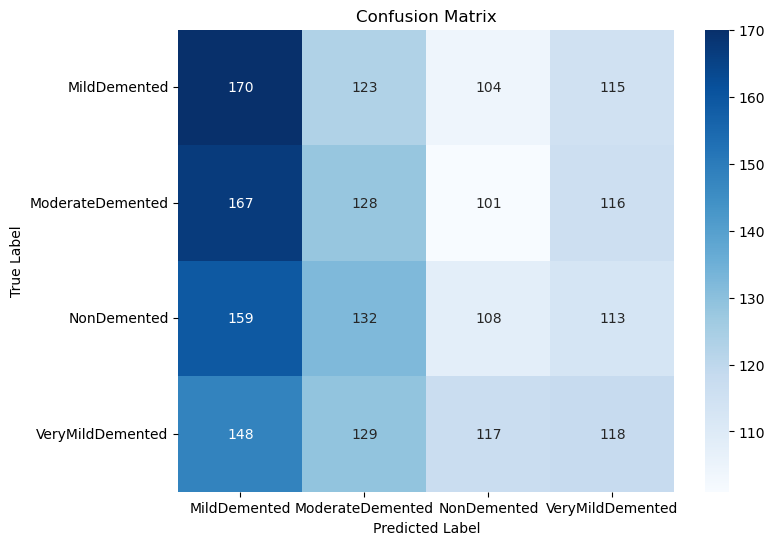

In [54]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
#save model
model.save('alzheimer_detection.h5')

/Users/qinmiaodeng/anaconda3/envs/csci1470/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
